In [1]:
import pandas as pd
import numpy as np

In [2]:
events = pd.read_pickle('events2.pkl')

In [3]:
sessions = pd.read_pickle('session4.pkl')

In [4]:
merged = events.merge(sessions, how='left', on=['user_id_hash', 'session_id'])

# EDA

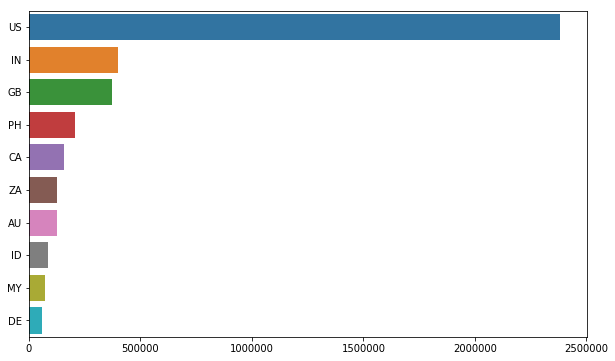

In [473]:
fig, ax = plt.subplots(figsize=(10,6))
top_countries = sessions.country.value_counts()[:10]
sns.barplot(y=list(top_countries.index), x=top_countries.values)
plt.savefig('Figures/Top_countries.png')
plt.show()

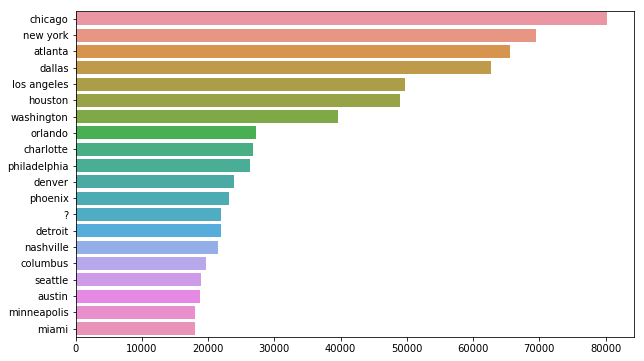

In [541]:
fig, ax = plt.subplots(figsize=(10,6))
top_US_cities = sessions.city[sessions.country == 'US'].value_counts()[:20]
sns.barplot(y=list(top_US_cities.index), x=top_US_cities.values)
plt.savefig('Figures/Top_US_Cities.png')
plt.show()

In [496]:
sessions['os_name'] = sessions.os_name.map({'Android OS': 'Android OS',
                                   'iOS': 'iOS', 
                                   'iPhone OS': 'iOS'})

In [497]:
sessions.shape

(5165760, 21)

In [498]:
top = sessions[sessions.country.isin(list(top_countries.index))].copy()
top['country'] = top.country.astype(str)

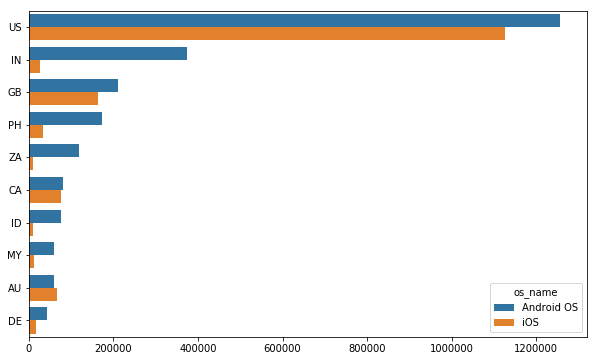

In [500]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y='country', hue='os_name', data=top,
             order=['US', 'IN', 'GB', 'PH', 'ZA', 'CA', 'ID',
                   'MY', 'AU', 'DE'])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig('Figures/OS_Country.png')

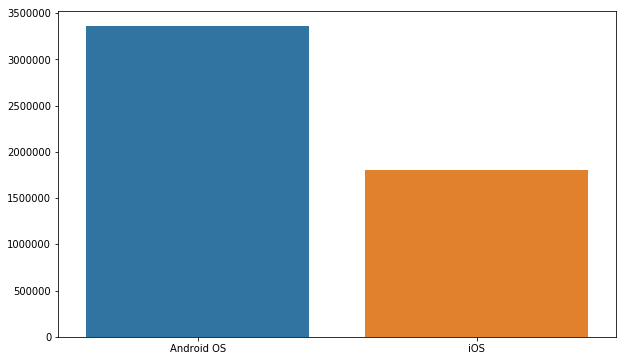

In [477]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(sessions.os_name.map({'Android OS': 'Android OS',
                                   'iOS': 'iOS', 
                                   'iPhone OS': 'iOS'}))
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('Figures/OS.png')
# plt.show()

In [508]:
valid_evs = events[events.event.isin(valid_events[:-1])]

In [509]:
valid_evs.shape[0]

109627797

In [510]:
events.shape[0]

111946597

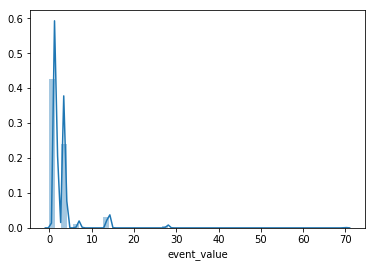

In [514]:
sns.distplot(valid_evs[valid_evs.event=='8'].event_value)

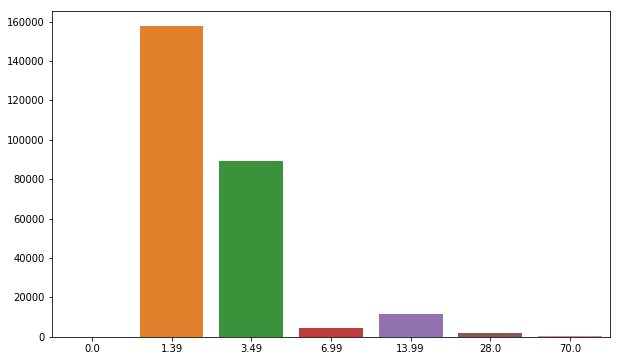

In [536]:
fig, ax = plt.subplots(figsize=(10,6))
purchase_amounts = valid_evs[valid_evs.event=='8'].event_value.astype(np.float16).value_counts().sort_index()
sns.barplot(x=[round(amt, 2) for amt in purchase_amounts.index], y=purchase_amounts.values)
plt.savefig('Figures/Purchase_amt.png')

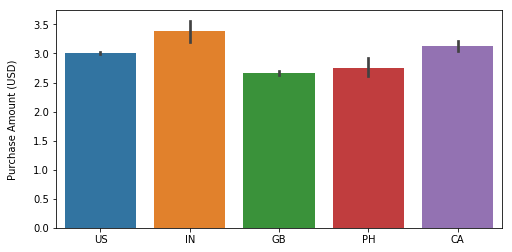

In [546]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='country', y='event_value',
            order=list(top_countries.index[:5]),
            data=merged[(merged.country.isin(list(top_countries.index[:5]))) & \
                       (merged.event == '8')])
ax.set_xlabel('')
ax.set_ylabel('Purchase Amount (USD)\n')
plt.savefig('Figures/Purchase_by_country.png')
plt.show()

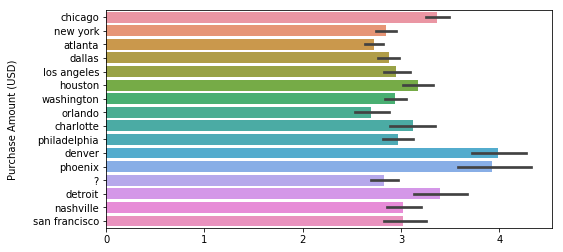

In [557]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(y='city', x='event_value',
            order=list(top_US_cities.index[:15]) + ['san francisco'],
            data=merged[(merged.city.isin(list(top_US_cities.index[:15]) + ['san francisco'])) & \
                       (merged.event == '8')])
ax.set_xlabel('')
ax.set_ylabel('Purchase Amount (USD)\n')
plt.savefig('Figures/Purchase_by_country.png')
plt.show()

In [554]:
merged[(merged.country == 'US') & (merged.event=='8')].groupby('city').event_value.mean()[list(top_US_cities.index) + ['san francisco']]

city
chicago          3.366538
new york         2.842871
atlanta          2.721286
dallas           2.882109
los angeles      2.948254
houston          3.174250
washington       2.941408
orlando          2.698731
charlotte        3.119268
philadelphia     2.969934
denver           3.985829
phoenix          3.926034
?                3.052236
detroit          3.391828
nashville        3.020425
columbus         2.805613
seattle          3.189308
austin           2.991707
minneapolis      3.446509
miami            2.922793
san francisco    3.024448
Name: event_value, dtype: float64

In [8]:
true_time = merged.start_timestamp[(~merged.start_timestamp.isna()) & (~merged.timezone_offset.isna())].astype(int)\
+ merged.timezone_offset[(~merged.start_timestamp.isna()) & (~merged.timezone_offset.isna())].astype(int)

In [9]:
from datetime import datetime

In [10]:
true_time[0]/1000

1542244164.58

In [11]:
true_time_obj = [datetime.utcfromtimestamp(time/1000) for time in true_time]

In [12]:
del(true_time)

In [13]:
time_users = merged[['session_id', 'user_id_hash',
                    'event', 'event_value']][(~merged.start_timestamp.isna()) & (~merged.timezone_offset.isna())]

In [14]:
time_users['true_time'] = true_time_obj

In [15]:
del(true_time_obj)

In [16]:
time_users['sesh_hour'] = time_users.true_time.dt.hour

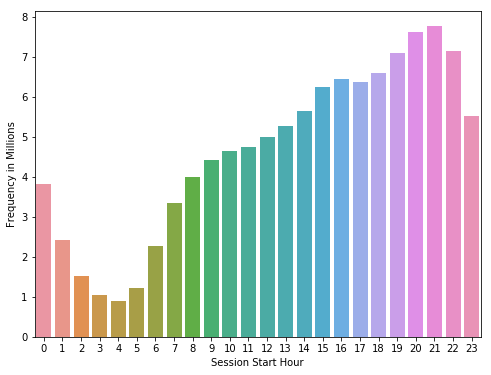

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x=time_users.sesh_hour)
ax.set_yticklabels(list(range(9)))
ax.set_ylabel('Frequency in Millions')
ax.set_xlabel('Session Start Hour')
plt.savefig('Figures/Session_start_hr.png')

In [22]:
event_time = merged[['event_timestamp']][(~merged.start_timestamp.isna()) & (~merged.timezone_offset.isna())]

In [41]:
len(event_time.values)

111079714

In [43]:
offset = np.asarray(merged.timezone_offset[(~merged.start_timestamp.isna()) & (~merged.timezone_offset.isna())])

In [50]:
ev_time = event_time.event_timestamp + offset.astype(int)

In [51]:
true_time_obj = [datetime.utcfromtimestamp(time/1000) for time in ev_time.values]

In [52]:
time_users['event_timestamp'] = true_time_obj

In [53]:
del(true_time_obj)

In [54]:
time_users['event_hour'] = time_users.event_timestamp.dt.hour

Text(0.5, 0, 'Purchase Hour')

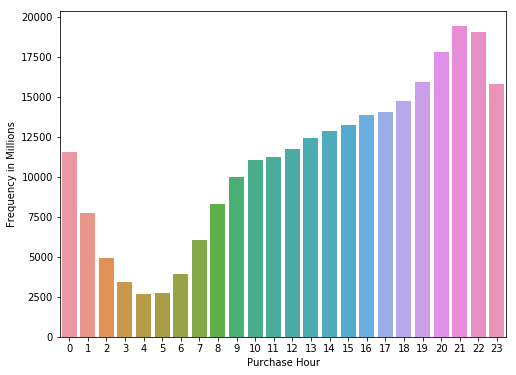

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x=time_users.event_hour[time_users.event=='8'])
ax.set_ylabel('Frequency in Millions')
ax.set_xlabel('Purchase Hour')
# plt.savefig('Figures/Purchase_hr.png')

In [56]:
time_users['event_sesh_start_difference'] = (time_users.event_timestamp - time_users.true_time).astype('timedelta64[m]')

In [57]:
time_users.event_sesh_start_difference.describe()

count    1.110797e+08
mean     2.498488e+01
std      3.481832e+01
min     -2.800000e+01
25%      5.000000e+00
50%      1.500000e+01
75%      3.200000e+01
max      7.503000e+03
Name: event_sesh_start_difference, dtype: float64

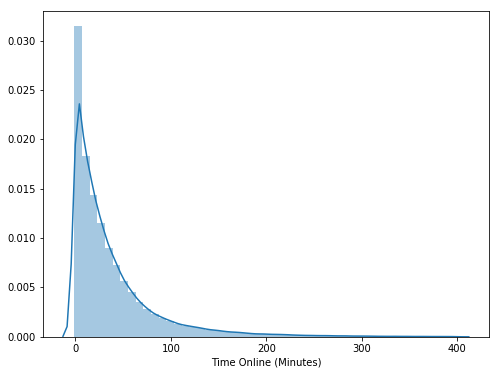

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot((time_users.event_sesh_start_difference[(time_users.event=='8') &\
             (time_users.event_sesh_start_difference <=400)]))
ax.set_xlabel('Time Online (Minutes)')
ax.set_xlim()
plt.savefig('Figures/Time_until_purchase.png')

In [73]:
time_users.event_sesh_start_difference[(time_users.event=='8')].describe()

count    264671.000000
mean         39.217504
std          52.563471
min          -1.000000
25%           7.000000
50%          22.000000
75%          50.000000
max         998.000000
Name: event_sesh_start_difference, dtype: float64